# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

# Start of the Assignment

In [8]:
# Read the temperature data to a pandas DataFrame
df_original = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

# df_original.head()

In [3]:
# Make a copy of the DataFrame
df_temp = df_original.copy()

# Convert the date column from string to datetime 
df_temp['Date'] = pd.to_datetime(df_temp['Date'])

# Divide the temperature by 10 to be more meaningful to the reader
df_temp['Data_Value'] = df_temp['Data_Value'] / 10

# Sort the DataFrame by date
df_temp = df_temp.sort_values('Date')

# df_temp.head()

In [4]:
# Create a column with only the month and day of the year
df_temp['month_day'] = df_temp['Date'].dt.strftime('%m-%d')

# Remove February 29th
df_temp = df_temp[df_temp['month_day'] != '02-29']

# df_temp.head()

In [5]:
# Create 4 Series
# 1) records low (2005-2014)
# 2) records high (2005-2014)
# 3) records broken (2015)
# 4) records broken (2015)

df_tmin_1 = df_temp[(df_temp['Element']=='TMIN') & (df_temp['Date'] < '2015')].copy()
df_tmax_1 = df_temp[(df_temp['Element']=='TMAX') & (df_temp['Date'] < '2015')].copy()
df_tmin_2 = df_temp[(df_temp['Element']=='TMIN') & (df_temp['Date'] >= '2015')].copy()
df_tmax_2 = df_temp[(df_temp['Element']=='TMAX') & (df_temp['Date'] >= '2015')].copy()

df_tmin_1 = df_tmin_1.groupby(['month_day']).min()['Data_Value']
df_tmax_1 = df_tmax_1.groupby(['month_day']).max()['Data_Value']
df_tmin_2 = df_tmin_2.groupby(['month_day']).min()['Data_Value']
df_tmax_2 = df_tmax_2.groupby(['month_day']).max()['Data_Value']

df_tmin_2 = df_tmin_2[df_tmin_2 < df_tmin_1]
df_tmax_2 = df_tmax_2[df_tmax_2 > df_tmax_1]

# df_tmin_1.head()

In [6]:
# Merge the Series in a DataFrame
df_all_temps = pd.merge(df_tmin_1.to_frame(), df_tmax_1.to_frame(), left_index=True, right_index=True, how='outer')
df_all_temps = pd.merge(df_all_temps, df_tmin_2.to_frame(), left_index=True, right_index=True, how='outer')
df_all_temps = pd.merge(df_all_temps, df_tmax_2.to_frame(), left_index=True, right_index=True, how='outer')

# Rename the columns
df_all_temps.columns = ['TMIN(2005-2014)', 'TMAX(2005-2014)', 'TMIN(2015)', 'TMAX(2015)']

# Adjust the index
df_all_temps.index = pd.to_datetime('2015-' + df_all_temps.index)

# df_all_temps.head()

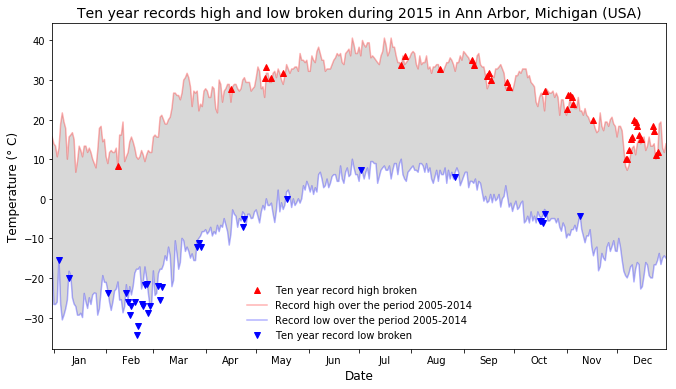

In [7]:
# Create the figure setting the size
plt.figure(figsize=(11,6))

# Plot the relevant data
df_all_temps['TMAX(2015)'].plot(color='red', linestyle='none', marker='^', label='Ten year record high broken')
df_all_temps['TMAX(2005-2014)'].plot(color='red', alpha=0.3, label='Record high over the period 2005-2014')
df_all_temps['TMIN(2005-2014)'].plot(color='blue', alpha=0.3, label='Record low over the period 2005-2014')
df_all_temps['TMIN(2015)'].plot(color='blue', linestyle='none', marker='v', label='Ten year record low broken')

# Get the current axis for modifications
ax = plt.gca()

# Create the shaded area
ax.fill_between(df_all_temps.index, 
                       df_all_temps['TMIN(2005-2014)'], df_all_temps['TMAX(2005-2014)'], 
                       facecolor='gray', 
                       alpha=0.3)

# Create a title
plt.title('Ten year records high and low broken during 2015 in Ann Arbor, Michigan (USA)', fontsize=14)

# Label the x axis
plt.xlabel('Date', fontsize=12)

# Label the y axis
plt.ylabel('Temperature (° C)', fontsize=12)

# Display the legend
legend = plt.legend()
legend.get_frame().set_linewidth(0.0)

# Center the months names
# See the link below
# https://matplotlib.org/3.1.0/gallery/ticks_and_spines/centered_ticklabels.html
import matplotlib.ticker as ticker
import matplotlib.dates as dates

ax.xaxis.set_major_locator(dates.MonthLocator())
# 16 is a slight approximation since months differ in number of days.
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')
# end of Center the months names

# Save the figure 
plt.savefig('assingment2.png', dpi=300)

# Display
plt.show()